In [ ]:
# This notebook will be used to work on the subimage problem
# The idea is to generate 20x20 subimages of the orginal double dots maps. 
# Each subimage will have a single label : one of single dot, double dot, QPC or ShortCircuit
# The label will be decided by the majority label in the subimage from the state classification problem


In [ ]:
# This input box will be used to generate sub image data and the corresponding labels.

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline

# this function finds the majority state in the subimage
def find_state(x,y,sub_size,dat):
    charge_map = list(dat.item()['state_map'][(x - int(sub_size/2)) :
                                     (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))].flatten())
    max_state = max(map(lambda val: (charge_map.count(val), val), set(charge_map)))[1]
    return max_state

# this function finds the prob. vector of the states corresponding to the subimage
def find_prob(x,y,sub_size,dat):
    prob = np.histogram(dat.item()['state_map']\
                    [(x - int(sub_size/2)) :(x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]\
                    .flatten(),[-1,0,1,2,3])[0]
    prob = prob/np.sum(prob)  

data_folder_path = "/Users/sandesh/dataproc/"
data_output_path = "/Users/sandesh/data_subimage/"
files = glob.glob(data_folder_path + "*.npy")

for file in files:
    dat = np.load(file)
    sub_size = 30
    n_sub_images = 10
    for i in range(n_sub_images):
        x = np.random.randint(int(sub_size/2),100-int(sub_size/2))
        y = np.random.randint(int(sub_size/2),100-int(sub_size/2))

        prob_state = find_prob(x,y,sub_size,dat)
        out = {}
        out['current_map'] = dat.item()['current_map'][(x - int(sub_size/2)) :
                                             (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]
        out['label'] = prob_state

        np.save(os.path.join(data_output_path,os.path.basename(file)[:-3] + "_30_subimage_" + str(i)),out)


[ 0.          0.          0.98888889  0.01111111]


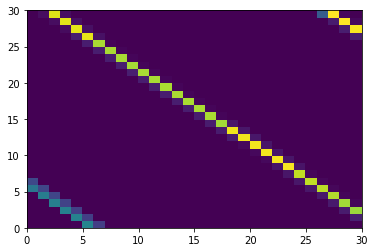

In [291]:
data_folder_path = "/Users/sandesh/dataproc/"
files = glob.glob(data_folder_path + "*.npy")

dat = np.load(files[1200])
x = np.random.randint(int(sub_size/2),100-int(sub_size/2))
y = np.random.randint(int(sub_size/2),100-int(sub_size/2))
prob = np.histogram(dat.item()['state_map']\
                    [(x - int(sub_size/2)) :(x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]\
                    .flatten(),[-1,0,1,2,3])[0]
prob = prob/np.sum(prob)
print(prob)
plt.pcolor(dat.item()['current_map']\
                    [(x - int(sub_size/2)) :(x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))])

1


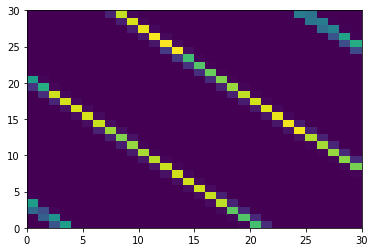

In [259]:
# Testing of the generated subimage data
data_folder_path = "/Users/sandesh/data_subimage/"
files = glob.glob(data_folder_path + "*.npy")
i = np.random.randint(len(files))
load_dat = np.load(files[i])

plt.pcolor(load_dat.item()['current_map'])
print(load_dat.item()['label'])

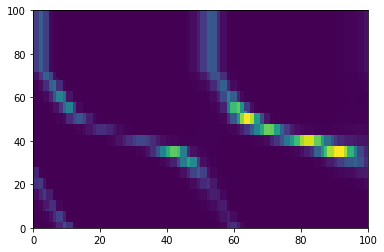

In [246]:
# Testing of the experimental data loading
import numpy as np
import scipy.interpolate

data_folder_path = "/Users/sandesh/exp_data/"
files = glob.glob(data_folder_path + "*.dat")

# Data format is V_LGD I_DC(nA) V_LGS I_AC(nA) t(sec)
# The format of the loaded array is [num_points,5]
dat = np.loadtxt(files[2])
sub_size = 100
grid_x = np.linspace(-1.4,-1.3,sub_size)
grid_y = np.linspace(-1.7,-1.6,sub_size)
xx,yy = np.meshgrid(grid_x,grid_y)
interpolated_data = scipy.interpolate.griddata((dat[:,0],dat[:,2]),dat[:,1],(xx, yy), method='nearest')

plt.pcolor(interpolated_data)
    

In [268]:
# CNN for learning!

# learn the states of a double dot
import numpy as np
import tensorflow as tf
import glob
import os

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features,[-1,30,30,1]),tf.float32)
    
    # Concolutional layer1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=4,
        kernel_size=[5,5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling layer1
    pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=[5,5],strides=5)

    # Dense layer
    pool2_flat = tf.contrib.layers.flatten(pool1)
    dense0 = tf.layers.dense(inputs=pool2_flat,units=512,activation=tf.nn.relu)
    dropout0 = tf.layers.dropout(inputs=dense0,rate=0.5,training=mode == learn.ModeKeys.TRAIN)
    
    dense1 = tf.layers.dense(inputs=dropout0,units=256,activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=dense1,rate=0.5,training=mode == learn.ModeKeys.TRAIN)
    
    dense2 = tf.layers.dense(inputs=dropout1,units=128,activation=tf.nn.relu)
    dropout2 = tf.layers.dropout(inputs=dense2,rate=0.5,training=mode == learn.ModeKeys.TRAIN)

    # encode layer
    encode = tf.layers.dense(inputs=dropout2,units=8)
    
    # dense output layer
    out_layer = tf.layers.dense(inputs=encode,units=1)

    loss = None
    train_op = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=out_layer)

    # Configure the training op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=0.1,
            optimizer="Adam")

    # Generate predictions
    predictions= {
        "states" : tf.rint(out_layer),
    }

    # Returna  ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode,predictions=predictions,loss=loss, train_op=train_op)
    
def get_train_inputs():
    n_batch = 50
    index = np.random.choice(np.arange(train_data.shape[0]),n_batch,replace=False)
    x = tf.constant(train_data[index])
    y = tf.constant(train_labels[index])
    return x,y

def get_test_inputs():
    x = tf.constant(test_data)
    y = tf.constant(test_labels)
    return x,y

# get the data
data_folder_path = "/Users/sandesh/data_subimage/"
files = glob.glob(data_folder_path + "*.npy")
inp = []
oup = []
for file in files[:10000]:
    data_dict = np.load(file).item()
    inp += [data_dict['current_map']]
    oup += [[data_dict['label']]]

inp = np.array(inp)
oup = np.array(oup)
n_samples = inp.shape[0]
train_sample_ratio = 0.9
n_train = int(train_sample_ratio * n_samples)

print("Total number of samples :",n_samples)
print("Training samples :",n_train)
print("Test samples :",n_samples - n_train)

train_data = inp[:n_train]
train_labels = oup[:n_train]

test_data = inp[n_train:]
test_labels = oup[n_train:]

# create the estimator
dd_classifier = learn.Estimator(model_fn=cnn_model_fn)

# set up logging for predictions
tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

metrics = {
    "accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states"),
}
for _ in range(10):
    dd_classifier.fit(
        input_fn=get_train_inputs,
        steps=1000,
        monitors=[logging_hook])
    
    eval_results=dd_classifier.evaluate(input_fn=get_train_inputs,metrics=metrics,steps=1)
    print("Train accuracy",eval_results)
    eval_results=dd_classifier.evaluate(input_fn=get_test_inputs,metrics=metrics,steps=1)
    print("Validation accuracy",eval_results)

print("Total number of samples :",n_samples)
print("Training samples :",n_train)
print("Test samples :",n_samples - n_train)
eval_results=dd_classifier.evaluate(input_fn=get_test_inputs,metrics=metrics,steps=1)
print("Test accuracy",eval_results)

Total number of samples : 10000
Training samples : 9000
Test samples : 1000
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_model_dir': None, '_save_summary_steps': 100, '_tf_random_seed': None, '_environment': 'local', '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11bdd34a8>, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_task_type': None, '_master': '', '_evaluation_master': ''}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpnlqony14/model.ckpt.
INFO:tensorflow:step = 1, loss = 1.78683
INFO:tensorflow:
INFO:tensorflow:global_step/sec: 32.5285
INFO:tensorflow:step = 101, loss = 1.8072 (3.074 sec)
INF

Validation accuracy {'accuracy': 0.60600001, 'global_step': 3000, 'loss': 0.30184838}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpnlqony14/model.ckpt-3000
INFO:tensorflow:Saving checkpoints for 3001 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpnlqony14/model.ckpt.
INFO:tensorflow:step = 3001, loss = 0.198804
INFO:tensorflow:global_step/sec: 37.136
INFO:tensorflow:step = 3101, loss = 0.193079 (2.694 sec)
INFO:tensorflow:global_step/sec: 37.0694
INFO:tensorflow:step = 3201, loss = 0.192447 (2.697 sec)
INFO:tensorflow:global_step/sec: 37.4462
INFO:tensorflow:step = 3301, loss = 0.192403 (2.670 sec)
INFO:tensorflow:global_step/sec: 36.4301
INFO:tensorflow:step = 3401, loss = 0.1924 (2.745 sec)
INFO:tensorflow:global_step/sec: 36.566
INFO:tensorflow:step = 3501, loss = 0.1924 (2.735 sec)
INFO:tensorflow:global_step/sec: 36.5446
INFO:tensorflow:step = 3601, loss = 0.1924 (2.736 sec)
INFO

INFO:tensorflow:step = 6601, loss = 0.2976 (2.770 sec)
INFO:tensorflow:global_step/sec: 36.5989
INFO:tensorflow:step = 6701, loss = 0.2976 (2.732 sec)
INFO:tensorflow:global_step/sec: 36.512
INFO:tensorflow:step = 6801, loss = 0.2976 (2.739 sec)
INFO:tensorflow:global_step/sec: 36.839
INFO:tensorflow:step = 6901, loss = 0.2976 (2.714 sec)
INFO:tensorflow:Saving checkpoints for 7000 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpnlqony14/model.ckpt.
INFO:tensorflow:Loss for final step: 0.2976.
INFO:tensorflow:Starting evaluation at 2017-06-28-21:57:42
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpnlqony14/model.ckpt-7000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-06-28-21:57:42
INFO:tensorflow:Saving dict for global step 7000: accuracy = 0.8, global_step = 7000, loss = 0.1744
Train accuracy {'accuracy': 0.80000001, 'global_step': 7000, 'loss': 0.17440003}
INFO:tensorflow:Starting evaluation at 20

Train accuracy {'accuracy': 0.63999999, 'global_step': 10000, 'loss': 0.37200004}
INFO:tensorflow:Starting evaluation at 2017-06-28-21:59:40
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpnlqony14/model.ckpt-10000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-06-28-21:59:41
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.606, global_step = 10000, loss = 0.285519
Validation accuracy {'accuracy': 0.60600001, 'global_step': 10000, 'loss': 0.28551948}
Total number of samples : 10000
Training samples : 9000
Test samples : 1000
INFO:tensorflow:Starting evaluation at 2017-06-28-21:59:41
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpnlqony14/model.ckpt-10000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-06-28-21:59:43
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.606, global_step = 10000, loss = 0.285519
T